In [8]:
#in this notebook I am tuning the SVC for predicting ice mask 
#I will use the original data to be consistent with the tuning for ice velocity and thickness already done 


import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

original_ice_mask = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

#shifting the columns so the target is the one furthest to the right -> needed for scaling to avoid scaling ice mask
original_ice_mask = original_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp','ice_mask']]

#removing fill values in ocean temp, for a fair comparison to the EF data
tolerance = 1e+30
original_ice_mask = original_ice_mask[(original_ice_mask['ocean_temp'] < (9.969210e+36 - tolerance))]

#removing those two rows in the dataset with ice mask = 0 
original_ice_mask = original_ice_mask[original_ice_mask['ice_mask']>0]


#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns[:-1]:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def doPolySVCWithTuning(preprocessed_df, seed, n_runs):
    best_params = []
    
    X = preprocessed_df.iloc[:, :-1]
    y = preprocessed_df.iloc[:, -1]
        
        
    for i in range(n_runs):
        randomState = i * seed
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState
                                                           , stratify = y)

        #define the model 
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced')

        # Set up the grid of parameters to search
        param_grid = {
            'C': [1, 10, 100, 1000],  # Regularization parameter
            'degree': [2, 3, 4, 5],  # Degree of the polynomial kernel
            'gamma': ['scale', 'auto'],  # Kernel coefficient
            'coef0': [1, 5, 10, 15] 
        }
            
        # Set up the grid search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)
        
        #store the best params from this run 
        best_params.append(grid_search.cv_results_['params'][grid_search.best_index_])

    print("Best Parameters per Run:", best_params)

    return best_params, param_grid
        


In [28]:
seed = 101
scaled_df = scale(original_ice_mask)
n_runs = 30
best_params, param_grid = doPolySVCWithTuning(scaled_df, seed, n_runs)


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 3

param counts
C
1        0
10       2
100     10
1000    18
Name: count, dtype: int64


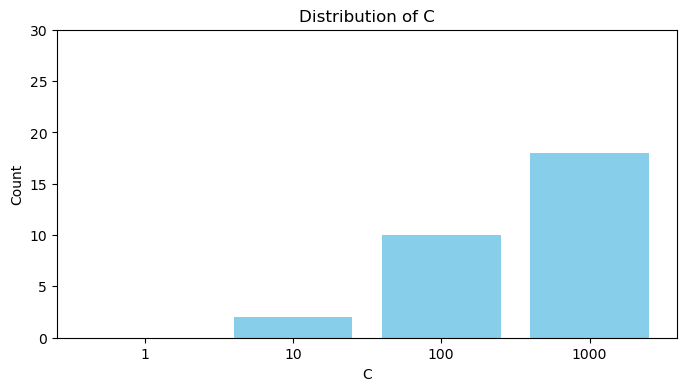

param counts
degree
2     0
3     0
4     5
5    25
Name: count, dtype: int64


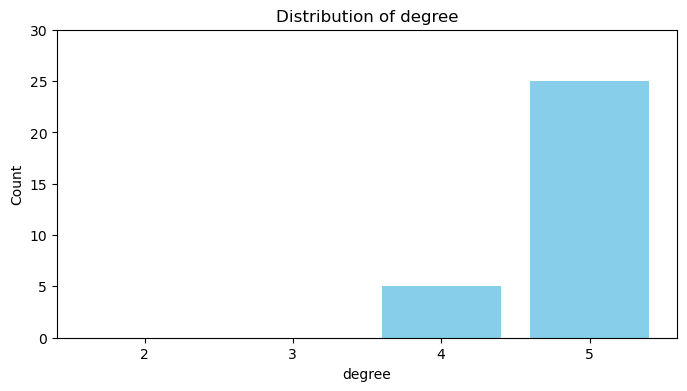

param counts
gamma
scale    30
auto      0
Name: count, dtype: int64


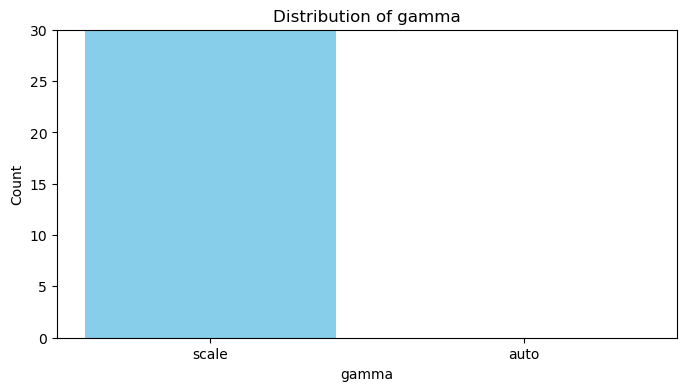

param counts
coef0
1      9
5     12
10     8
15     1
Name: count, dtype: int64


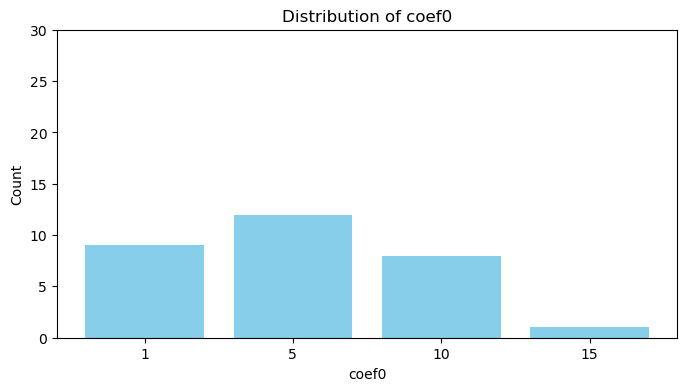

In [29]:
import matplotlib.pyplot as plt

def visualize_parameter_distribution_no_grid(param_dict, param_grid, n_runs):
    # Convert 'None' to string 'None' for 'max_depth'
    for d in param_dict:
        if 'max_depth' in d and d['max_depth'] is None:
            d['max_depth'] = 'None'
    
    # Convert the dictionary to a DataFrame for easier manipulation
    df = pd.DataFrame(param_dict)

    # Loop through each parameter in the grid and create separate bar charts
    for param, values in param_grid.items():
        
        if param == "max_depth":
            values = ['None' if v is None else v for v in values]
            
        
        # Count the occurrences of each parameter value in the dictionary
        param_counts = df[param].value_counts().reindex(values, fill_value=0)
        print("param counts")
        print(param_counts)
        # Plot the bar chart for the parameter
        plt.figure(figsize=(8, 4))
        plt.bar(param_counts.index.astype(str), param_counts.values, color='skyblue')
        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Count')
        plt.ylim(0, n_runs)  # Set y-axis limit to n_runs
        plt.show()

# Call the function with the 'n_runs' parameter
n_runs=30
visualize_parameter_distribution_no_grid(best_params, param_grid, n_runs)

In [37]:
def doTunedPolySVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        print(i)
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced', 
                   degree = 5, gamma = 'scale', C = 0.1, coef0 = 5)
        model.fit(X_train, y_train)
        
        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    
seed = 101
scaled_df = scale(original_ice_mask)
n_runs = 30
doTunedPolySVC(scaled_df, seed, n_runs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Average Training Accuracy: 0.943, Std: 0.004
Training Category Metrics:
  grounded_ice: Avg: 0.868, Std: 0.010
  floating_ice: Avg: 0.998, Std: 0.007
  open_ocean: Avg: 0.987, Std: 0.004

Average Test Accuracy: 0.926, Std: 0.008
Test Category Metrics:
  grounded_ice: Avg: 0.853, Std: 0.018
  floating_ice: Avg: 0.790, Std: 0.081
  open_ocean: Avg: 0.980, Std: 0.007
